# Algoritmos e Estrutura de Dados II - Projeto Final

## Introdução

Este trabalho tem como objetivo montar uma rede de páginas do Wikipedia, ligadas pelos seus Hyperlinks.

Para isso, utilizou-se bibliotecas Python que auxiliam na montagem e visualização de grafos, como o NetworX, o Wikipedia para extrair as informações e Seaborn e Matplotlib para análise de dados.

Este Notebook foi dividido entre os 5 requisitos necessários que foram explicitados na instrução desta avaliação.

## Aluno

Avaliação realizada pelo aluno Mateus Cavalcanti Alves Teixeira Silva

## Requisito 1

O Requisito 1 consistiu na extração de páginas do Wikipedia e a montagem do Grafo por meio do NetworkX.

Para isso, definiu-se três SEEDS para a realização das buscas, sendo estas: "Culinária do Norte do Brasil", "Artesanato Brasileiro" e "Festas Juninas".

Além disso, foram definidas também um conjunto de "stop words", que são hyperlinks comuns de páginas do Wikipedia que não se relacionam com o assunto de nossa busca, portanto devemos ignorá-las.

Ademais, limitou-se a número de camadas da rede em 2, assim evitando um tempo de processamento muito extenso e páginas que fogem bastante do escopo da pesquisa.

Após a montagem da rede, foram removidos "self-loops" e duplicatas para melhorar a visualização.

Por fim, exportou-se o grafo gerado e criou-se uma imagem de melhor visualização no Gephi.

In [6]:
!pip install wikipedia networkx matplotlib seaborn

import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define as novas SEEDs (páginas iniciais)
SEEDS = ["Culinária do Norte do Brasil ", "Artesanato Brasileiro", "Festas Juninas"]

# Define as STOP words
STOPS = (
    "International Standard Serial Number",
    "International Standard Book Number",
    "National Diet Library",
    "International Standard Name Identifier",
    "International Standard Book Number (Identifier)",
    "Wayback Machine",
    "Issn (Identifier)",
    "S2Cid (Identifier)",
    "Jstor (Identifier)",
    "Oclc (Identifier)",
    "Pubmed Identifier",
    "Pubmed Central",
    "Digital Object Identifier",
    "Arxiv",
    "Proc Natl Acad Sci Usa",
    "Bibcode",
    "Library Of Congress Control Number",
    "Jstor",
    "Doi (Identifier)",
    "Isbn (Identifier)",
    "Pmid (Identifier)",
    "Arxiv (Identifier)",
    "Bibcode (Identifier)",
)

In [ ]:
# Inicializa as listas e conjuntos para controle do processamento
todo_lst = [(0, seed) for seed in SEEDS]  # Cada SEED está na camada 0
todo_set = set(SEEDS)  # SEEDs como conjunto
done_set = set()  # Nada foi processado ainda

# Inicializa o grafo dirigido
g = nx.DiGraph()

In [ ]:
while todo_lst:
    layer, page = todo_lst[0]

    # Limitar a profundidade da rede para 2
    if layer >= 2:
        break

    # Remove a página atual da lista e adiciona ao conjunto de páginas processadas
    del todo_lst[0]
    done_set.add(page)

    # Tenta fazer o download da página selecionada
    try:
        wiki = wikipedia.page(page)
    except:
        print("Could not load", page)
        continue

    # Adiciona os links da página ao grafo
    for link in wiki.links:
        link = link.title()
        if link not in STOPS and not link.startswith("List Of"):
            if link not in todo_set and link not in done_set:
                todo_lst.append((layer + 1, link))
                todo_set.add(link)
            g.add_edge(page, link)

Could not load Cashew
Could not load St. John The Baptist Cathedral (Disambiguation)
Could not load Darts


In [ ]:
# Cria uma cópia original do grafo
original = g.copy()

# Remove self-loops
g.remove_edges_from(nx.selfloop_edges(g))

# Identifica e remove duplicatas, como 'network' e 'networks'
duplicates = [(node, node + "s") for node in g if node + "s" in g]

for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

# Identifica e remove duplicatas com hífens
duplicates = [
    (x, y)
    for x, y in [(node, node.replace("-", " ")) for node in g]
    if x != y and y in g
]

for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

# Ajusta atributos de contração para compatibilidade com GraphML
nx.set_node_attributes(g, 0, "contraction")
nx.set_edge_attributes(g, 0, "contraction")

# Filtra os nós com grau maior ou igual a 2
core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

# Seleciona um subgrafo com os nós principais
gsub = nx.subgraph(g, core)

# Salva o grafo em formato GraphML para uso no Gephi
nx.write_graphml(gsub, "wikipedia_network.graphml")

A imagem abaixo é o resultado do pós-processamento do grafo criado acima por meio do software Gephi. Para a criação deste, realizou-se as seguintes operações:

- Selecionou-se o Layout de Force Atlas II pois este é eficiente em revelar comunidades ou clusters dentro da rede. Os nós que estão mais fortemente conectados tendem a se agrupar juntos, o que pode ajudar a identificar subgrupos ou comunidades dentro da rede.

- Utilizou-se a estatística de Modularidade para a detecção de comunidades, totalizando 5 destas.

- Utilizou-se estatísticas de centralidade de autovetor e distância média de caminhos para análises que serão discutidas à posteriori neste Notebook.

- Utilizou-se a métrica do in-degree dos nós para destacar nós mais importantes da rede. Esta estatística nos revela as páginas que são mais citadas nesta rede.

- Utilizou-se filtro para apresentar os nomes dos nós com maior número de in-degree.

Na imagem, pode-se observar que páginas como "Umbanda", "Religion in Brazil", "Portuguese Language" e "Colonization" são amplamente citadas.

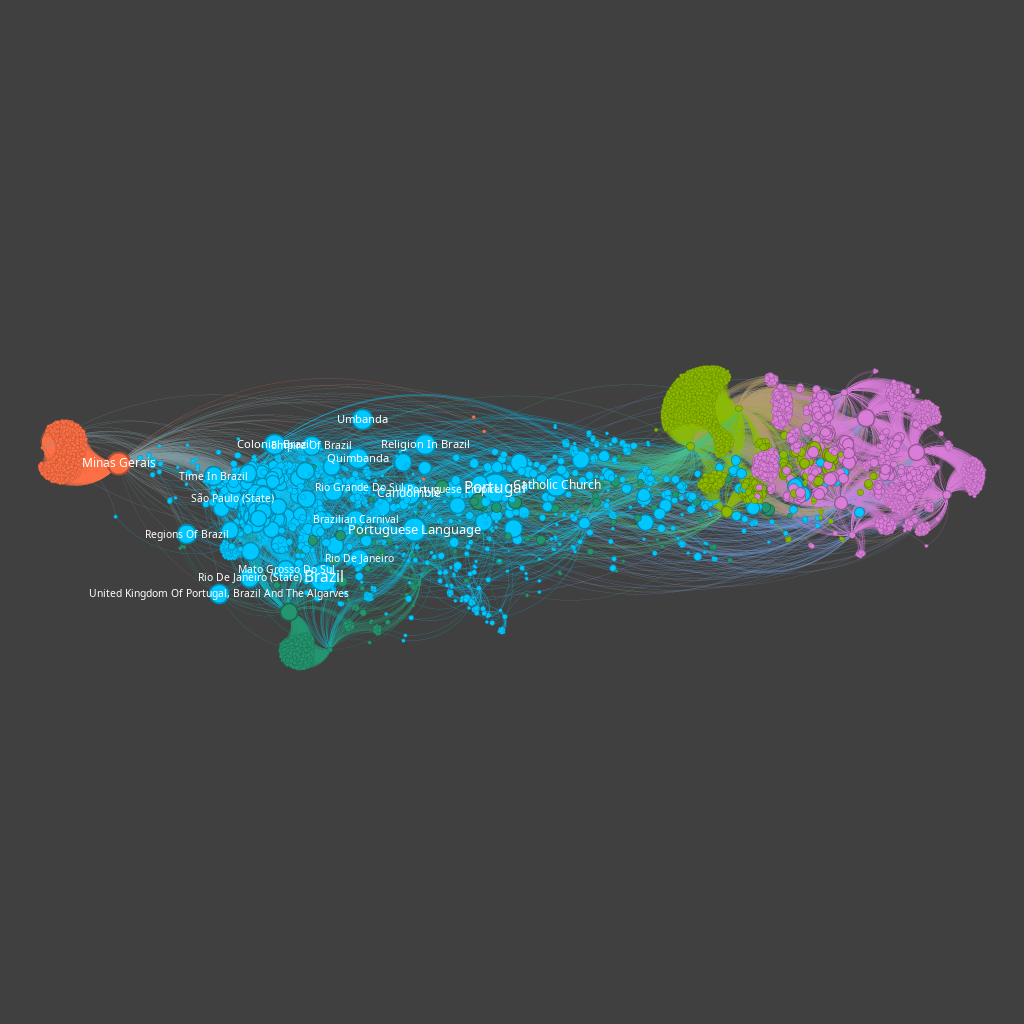

## Requisito 2

Para a realização do requisito 2, com o objetivo de gerar um gráfico de melhor visualização, importou-se o arquivo .graphml gerado via gephi, onde mantivemos as informações das posições dos nós obtidas por meio do Layout do Force Atlas II.

A partir disso, foram geradas as informações acerca das propriedades:

- degree centrality;
- closeness centrality;
- betweenness centrality;
- eigenvector centrality;



In [8]:
# Carregar o grafo do arquivo GraphML (ou outro formato)
G = nx.read_graphml("grafo_gephi.graphml")

# Extrair posições dos nós a partir dos atributos 'x' e 'y'
pos = {}
for node in G.nodes:
    try:
        x = float(G.nodes[node]['x'])
        y = float(G.nodes[node]['y'])
        pos[node] = (x, y)
    except KeyError:
        # Ignora nós sem coordenadas 'x' ou 'y'
        pass

# Criar subgrafo apenas com os nós que possuem posições
G_sub = G.subgraph(pos.keys())

In [ ]:
# Calcular centralidades no subgrafo
degree_centrality = nx.degree_centrality(G_sub)
closeness_centrality = nx.closeness_centrality(G_sub)
betweenness_centrality = nx.betweenness_centrality(G_sub)
eigenvector_centrality = nx.eigenvector_centrality(G_sub)

<ipython-input-48-41c6d18ec5ff>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


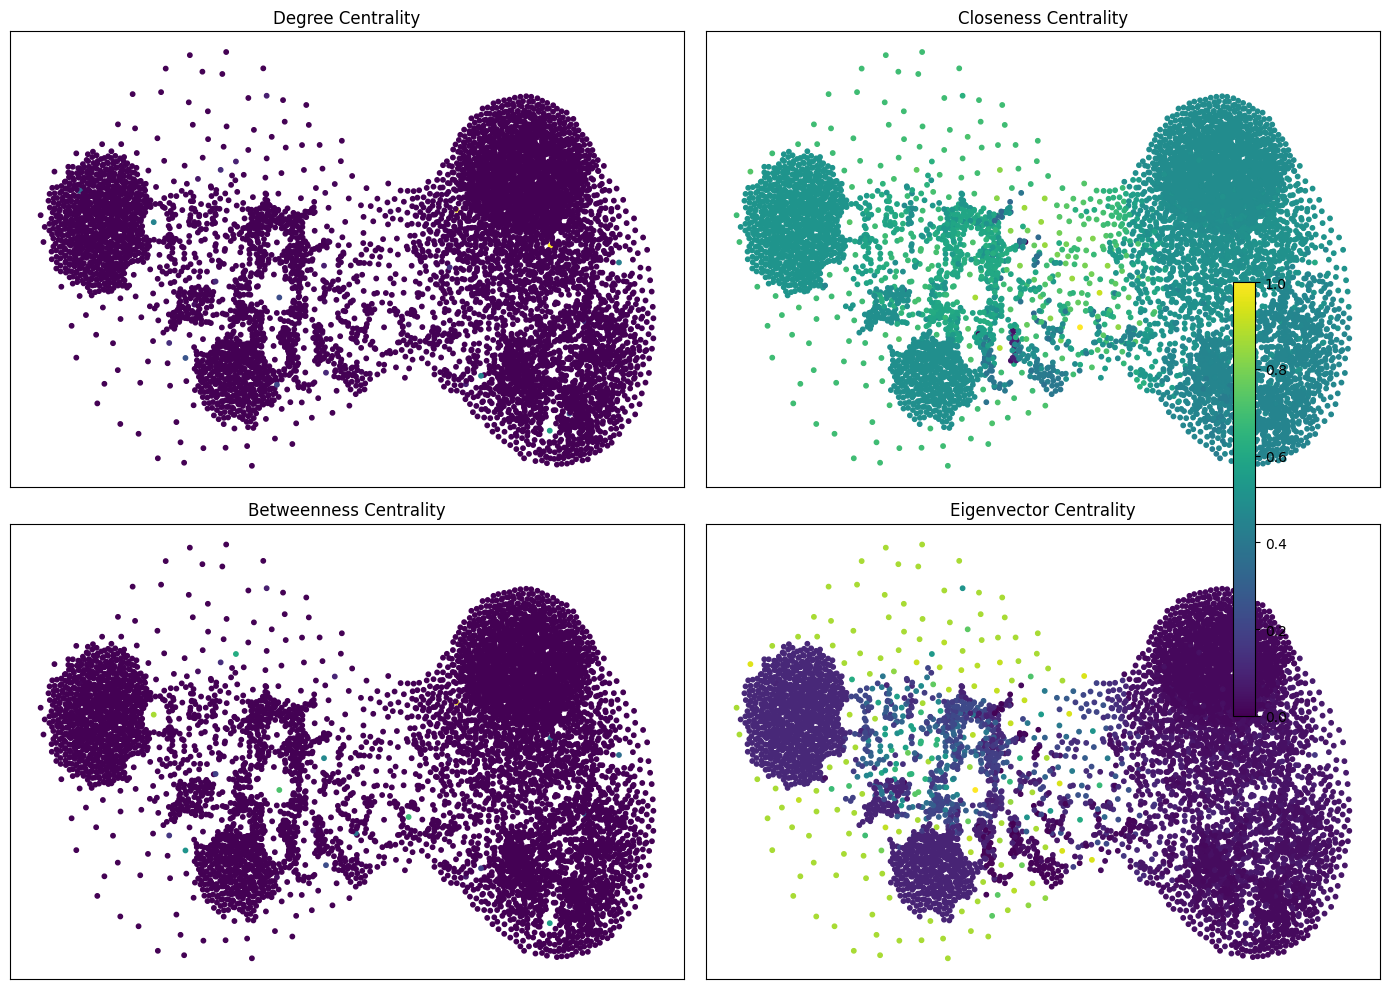

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
cmap = plt.cm.viridis

# Plotar Degree Centrality
nx.draw_networkx(
    G_sub, pos, node_color=list(degree_centrality.values()), cmap=cmap, ax=axs[0, 0], with_labels=False, node_size=10, edgelist=[]
)
axs[0, 0].set_title('Degree Centrality')

# Plotar Closeness Centrality
nx.draw_networkx(
    G_sub, pos, node_color=list(closeness_centrality.values()), cmap=cmap, ax=axs[0, 1], with_labels=False, node_size=10, edgelist=[]
)
axs[0, 1].set_title('Closeness Centrality')

# Plotar Betweenness Centrality
nx.draw_networkx(
    G_sub, pos, node_color=list(betweenness_centrality.values()), cmap=cmap, ax=axs[1, 0], with_labels=False, node_size=10, edgelist=[]
)
axs[1, 0].set_title('Betweenness Centrality')

# Plotar Eigenvector Centrality
nx.draw_networkx(
    G_sub, pos, node_color=list(eigenvector_centrality.values()), cmap=cmap, ax=axs[1, 1], with_labels=False, node_size=10, edgelist=[]
)
axs[1, 1].set_title('Eigenvector Centrality')

# Adicionar barra de cor
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02)

plt.tight_layout()
plt.show()

Nas imagens acima, foram removidas as arestas do grafo para melhor visualização.

A partir disso, pode-se inferir as seguintes afirmações:

- Degree centrality: Praticamente todos os nós possuem a mesma cor (roxa), indicando que há poucos "Hubs" nesta rede. Com isso, pode-se inferir que há poucas páginas que são amplamente citadas.

- Closeness Centrality: A maioria dos nóis possui a mesma cor para esta propriedade, indicando que a distância média entre a maioria dos nós é a mesma. Isto pode também ser influenciado pela limitação da rede a possuir duas camadas. Talvez, com um número maior de camadas, ocorresse uma diferença neste gráfico. De qualquer maneira, alguns poucos nodos possuem um maior número de Closeness Centrality, indicando que estes atuam como "nodos" principais, podendo alcançar mais rapidamente outros nós da rede.

- Betweenness Centrality: A maioria dos nodos possui a mesma Betweenness Centrality (roxa) sugerindo que a maioria dos nós na rede tem uma centralidade de intermediação baixa. Em outras palavras, a maior parte das páginas da Wikipedia na rede não desempenham um papel importante como intermediária entre outros pares de páginas.

- Eigenvector Centrality: O gráfico indicar que há poucos nós com alta centralidade e muitos nós de baixa centralidade. Isto indica que há poucos nós "importantes", que servem como "Hubs" para esta rede. Ou seja, temos algumas páginas mais relevantes e muitas páginas pouco relevantes.

## Requisito 3

A partir desta rede, também foram gerados gráficos acerca da função de densidade de probabilidade e de função de densidade acumulada, levando em consideração o in-degree dos nodos da rede.

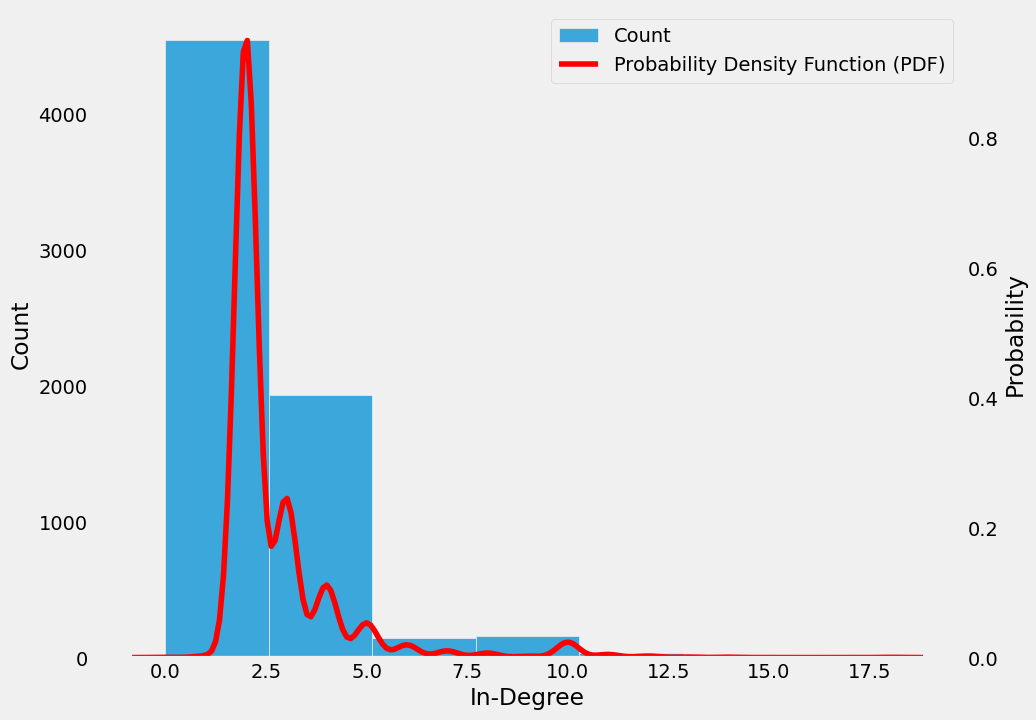

In [ ]:
# Calcular o in-degree dos nós
in_degrees = dict(G_sub.in_degree())
in_degree_sequence = list(in_degrees.values())

# Plotar gráfico para in-Degree
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.histplot(in_degree_sequence, bins=7, label="Count", ax=ax)
ax2 = ax.twinx()
sns.kdeplot(in_degree_sequence, color='r', label="Probability Density Function (PDF)", ax=ax2)

# Combinar legendas
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# Configurações de estilo
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("In-Degree")
ax2.set_ylabel("Probability")
plt.show()

O gráfico acima indica que a maior parte das páginas na Wikipédia recebe um número relativamente pequeno de links. Isso é evidenciado pela alta frequência de páginas com grau de entrada próximo de zero a dois. Há um número menor de páginas que recebem muitos links. Essas páginas são consideradas "hubs" na rede, pois são referenciadas por um grande número de outras páginas. A distribuição assimétrica sugere uma hierarquia de informação na Wikipédia. Há um pequeno número de páginas centrais que são amplamente referenciadas e que servem como pontos de partida para explorar diferentes tópicos. A maioria das páginas, por outro lado, são mais específicas e menos conhecidas.

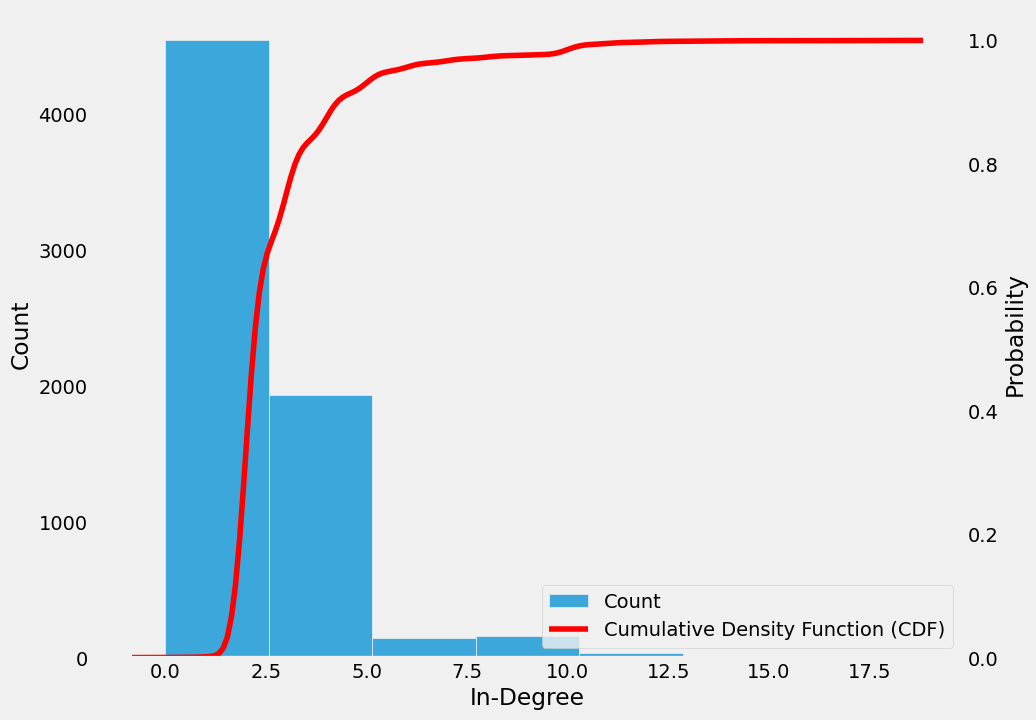

In [ ]:
# Plotar gráfico para in-Degree com CDF
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Histograma
sns.histplot(in_degree_sequence, bins=7, label="Count", ax=ax)
ax2 = ax.twinx()

# CDF
sns.kdeplot(in_degree_sequence, color='r', label="Cumulative Density Function (CDF)", ax=ax2, cumulative=True)

# Combinar legendas
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# Configurações de estilo
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("In-Degree")
ax2.set_ylabel("Probability")
plt.show()


A curva sobe rapidamente no início, indicando que a maioria dos nós possui um grau de entrada baixo. Isso confirma a observação anterior de que a maioria das páginas na Wikipédia recebe poucos links. Além disso, a curva se aproxima de 1 de forma gradual, indicando a presença de uma longa cauda na distribuição. Isso significa que existe um pequeno número de páginas com um grau de entrada muito alto, o que contribui para a assimetria da distribuição. A CDF confirma a existência de uma grande desigualdade na distribuição de links na Wikipédia. Poucas páginas concentram a maior parte dos links, enquanto a maioria das páginas recebe poucos links.

# Requisito 4

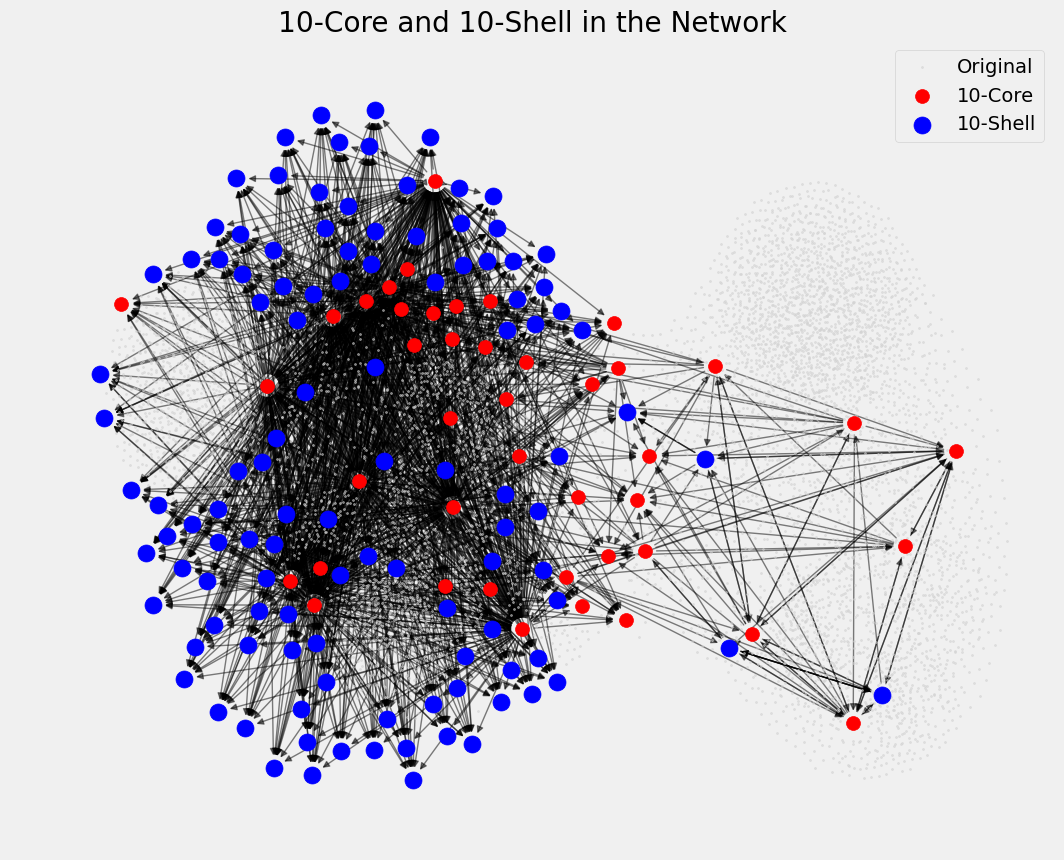

In [14]:
k = 10
k_core = nx.k_core(G, k)

# Encontrar os k-shells
k_shell = nx.k_shell(G, k)

# Criar a figura
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12, 10))

# Desenhar o grafo original
nx.draw_networkx_nodes(G_sub, pos, node_size=2, node_color='lightgrey', alpha=0.6, label="Original")
# nx.draw_networkx_edges(G_sub, pos, alpha=0.3)

# Desenhar o k-core
nx.draw_networkx_nodes(k_core, pos, node_size=100, node_color='red', label=f"{k}-Core")
nx.draw_networkx_edges(k_core, pos, alpha=0.5)

# Desenhar o k-shell
nx.draw_networkx_nodes(k_shell, pos, node_size=150, node_color='blue', label=f"{k}-Shell")
nx.draw_networkx_edges(k_shell, pos, alpha=0.7)

# Adicionar legenda e títulos
ax.legend()
ax.set_title(f"{k}-Core and {k}-Shell in the Network")
ax.axis('off')
plt.show()

Os nós em vermelho representam o 10-Core da rede. Isso significa que cada um desses nós está conectado a pelo menos outros 10 nós dentro desse subgrafo altamente conectado. O 10-Core representa o núcleo central da rede, onde as conexões são mais densas e os nós são mais influentes. São as páginas mais importantes e influentes, que servem como pilares para a construção do conhecimento na Wikipedia. As páginas do 10-Core provavelmente são de alta qualidade, bem escritas e amplamente referenciadas. Elas servem como fontes confiáveis de informação para diversos outros tópicos. Como há poucas destas páginas neste rede, elas acabam atuando como "hubs".



## Requisito 5

A rede obtida e processada pelo Gephi está disponível em produção e pode ser visualizada [nesta página](https://matscats.github.io/wikipedia-graph-deploy/network/).

Para a realização desta página, reitero que foi utilizado o Layout de Force Atlas II; Modularity para a identificação de comunidades e in-degree para tamanho dos nós.